# Подготовка данных

## Подгрузка данных и импорт иблиотек

Импортируем библиотеки, подгружаем обраотанный на предыдущем этапе стажировки датасет, убрав ненужные на данном этапе столбцы.

In [92]:
!gdown --id 1-S0rhPPdmg2cO8iHpXAsdA4qfRZKevEd

import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as lm
import matplotlib as mpl

ds = pd.read_excel('clear_set.xlsx')
ds = ds[['spec', 'salary', 'schedule', 'experience']]
works = ['Удаленная работа', 'Полный день', 'Гибкий график', 'Вахтовый метод', 'Сменный график']
def work_type(text):
  for i in range(len(works)):
    if works[i] in text:
      return works[i];

ds.schedule = ds.schedule.apply(work_type)


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-S0rhPPdmg2cO8iHpXAsdA4qfRZKevEd
To: /content/clear_set.xlsx
100% 4.67M/4.67M [00:00<00:00, 314MB/s]


In [93]:
ds.groupby('schedule').count()

,spec,salary,experience
schedule,,,
Вахтовый метод,28,28,28
Гибкий график,581,581,581
Полный день,10513,10513,10513
Сменный график,96,96,96
Удаленная работа,2291,2291,2291


Оставим для сравнения вакансии с удаленной занятостью и с полной занятостью в офисе, чтобы выяснить, насколько реально в регионах с небольшим предложением вакансий найти удаленную работу после курсов.   

In [94]:
filter = ds['schedule'].apply(lambda x: x in ['Удаленная работа', 'Полный день'])
ds = ds[filter]
ds.groupby('schedule').count()

,spec,salary,experience
schedule,,,
Полный день,10513,10513,10513
Удаленная работа,2291,2291,2291


# Гипотеза

**Гипотеза H0** - уровень зарплаты не зависит от опыта работы

**Гипотеза H1** - опыт работы влияет на уровень заработной платы.


Зададим уровень значимости альфа равным 0.05

# Структурированные данные для проверки гипотезы

Просмотрим, что из себя представляет наш датасет:

In [95]:
ds[['spec','salary','experience','schedule']].head()

,spec,salary,experience,schedule
0,Специалист по тестированию,55000.0,1,Удаленная работа
1,Специалист по тестированию,210000.0,3,Удаленная работа
2,Специалист по тестированию,175000.0,3,Удаленная работа
3,Специалист по тестированию,210000.0,1,Удаленная работа
4,Специалист по тестированию,99999.0,0,Полный день


In [96]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12804 entries, 0 to 13508
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   spec        12804 non-null  object 
 1   salary      12804 non-null  float64
 2   schedule    12804 non-null  object 
 3   experience  12804 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 500.2+ KB


Типы танных:
* **spec** - название вакансии, строковой тип (**категориальный тип**)
* **salary** - предлагаяемая средняя зараотная плата, число с плавающей точкой (**количественный тип**) 
* **experience** - требуемый опыт, челочисленный (**порядковый тип**)
* **schedule** - тип занятости (**категориальный тип**)

In [97]:
ds.experience.unique()

array([1, 3, 0, 6])

Пропуски отсутствуют, опыт работы представляет собой порядковые данные разделенные на 4 группы:
* 0 - нет опыта работы
* 1 - от 1 до 3 лет
* 3 - от 3 до 6 лет
* 6 - более 6 лет

Мы хотим понять, зависят ли количественные данные - предлагаемая работодателем зарплата от требований по опыту.

Для количественных данных мы можем расчитать числовые хароактериситки. Вглянем на них (сгрупировав зарплаты по требованию к опыту):

In [98]:
ds.groupby('experience')['salary'].median()

experience
0     42500.0
1     80000.0
3    130000.0
6    174300.0
Name: salary, dtype: float64

In [99]:
ds.groupby('experience')['salary'].describe()

,count,mean,std,min,25%,50%,75%,max
experience,,,,,,,,
0,1311.0,54679.479024,41416.845848,15494.0,30000.0,42500.0,60000.0,350000.0
1,7200.0,94797.530486,58537.597112,16657.0,50000.0,80000.0,120000.0,550000.0
3,3937.0,149204.259716,86970.318261,16000.0,80000.0,130000.0,200000.0,717000.0
6,356.0,204451.213483,126963.878815,21500.0,110000.0,174300.0,275000.0,840000.0


Видим, что характеристики по всей видимости зависят от наличия опыта, медиана и среднее не совпадают, но оносительно близки, скорее всего распределение в выборках по опыту смещено. 

Для проверки гипотезы разобьем датасет на 4  по требуемому опыту

In [100]:
exp0 = ds[ds.experience == 0]
exp1 = ds[ds.experience == 1]
exp3 = ds[ds.experience == 3]
exp6 = ds[ds.experience == 6]

# Визуализация

Построим боксплоты чтобы посмотреть наличие выбросов в выборках

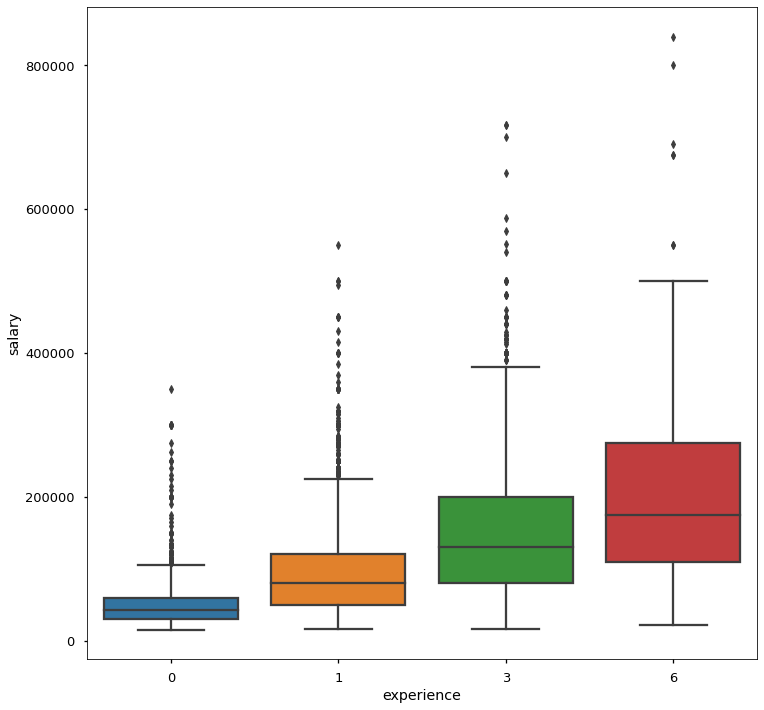

In [101]:
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x='experience', y='salary', data=ds)
mpl.style.use(['seaborn-talk'])


Видим, что ящики ассиметричны, что дает нам право с высокой вероятностью утверждать,что значения в выборках не сообветствуют нормальному распределению. Так ли это - проверим в дальнейшем.

## Уберем выбросы:
для этого вычислим для каждой из выборок: 
* Q1 - 1 квартиль
* Q3 - 3 квартиль
* IQR - межквартильный размах 

и оставим только значения из диапазона **(Q1 - 1.5 x IQR, Q3 + 1.5 x IQR)**

In [102]:
Q1 =  exp0.salary.quantile(0.25)
Q3 = exp0.salary.quantile(0.75)
IQR = Q3 - Q1
def drop_v(x):
  return (x > Q1-1.5*IQR ) and (x < Q3+1.5*IQR)
exp0 = exp0[exp0.salary.apply(drop_v)]  

Q1 =  exp1.salary.quantile(0.25)
Q3 = exp1.salary.quantile(0.75)
IQR = Q3 - Q1
exp1 = exp1[exp1.salary.apply(drop_v)] 

Q1 =  exp3.salary.quantile(0.25)
Q3 = exp3.salary.quantile(0.75)
IQR = Q3 - Q1
exp3 = exp3[exp3.salary.apply(drop_v)] 

Q1 =  exp6.salary.quantile(0.25)
Q3 = exp6.salary.quantile(0.75)
IQR = Q3 - Q1
exp6 = exp6[exp6.salary.apply(drop_v)] 

Соединим очищеные от выбросов датасеты, и взглянем еще раз на боксплоты 

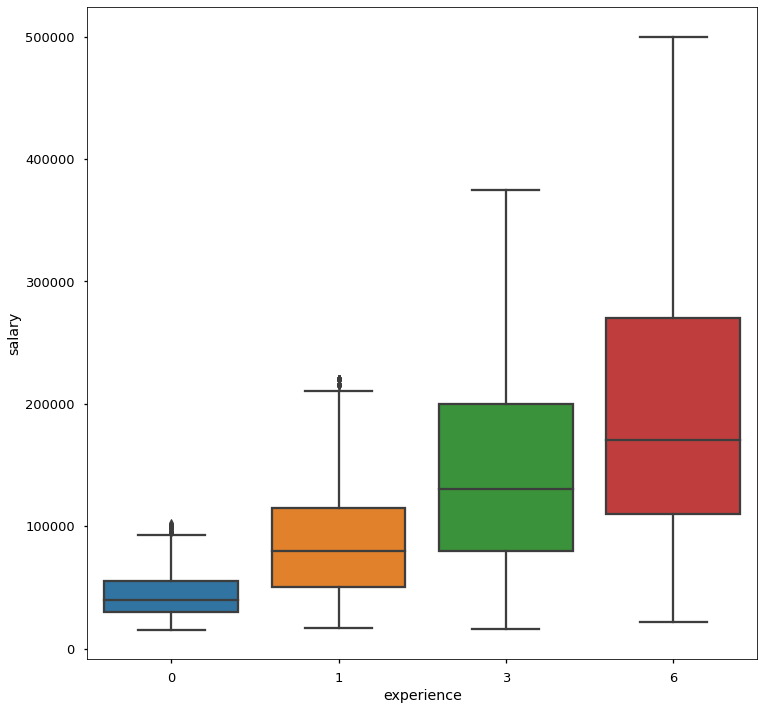

In [103]:

exp = exp0.merge(exp1, how='outer'); 
exp = exp.merge(exp3, how='outer'); 
exp = exp.merge(exp6, how='outer');   
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x='experience', y='salary', data=exp)

Из графика мы уже видим, что имеется зависимость заработной платы от опыта. Медианные значения не совпадают, насколько это несовпадение существенно - проверим с помощью критериев проверки статистических гипотез. 


### Проверим распределение количественной переменной - заработной платы на нормальность. Для начала построим гистограму.

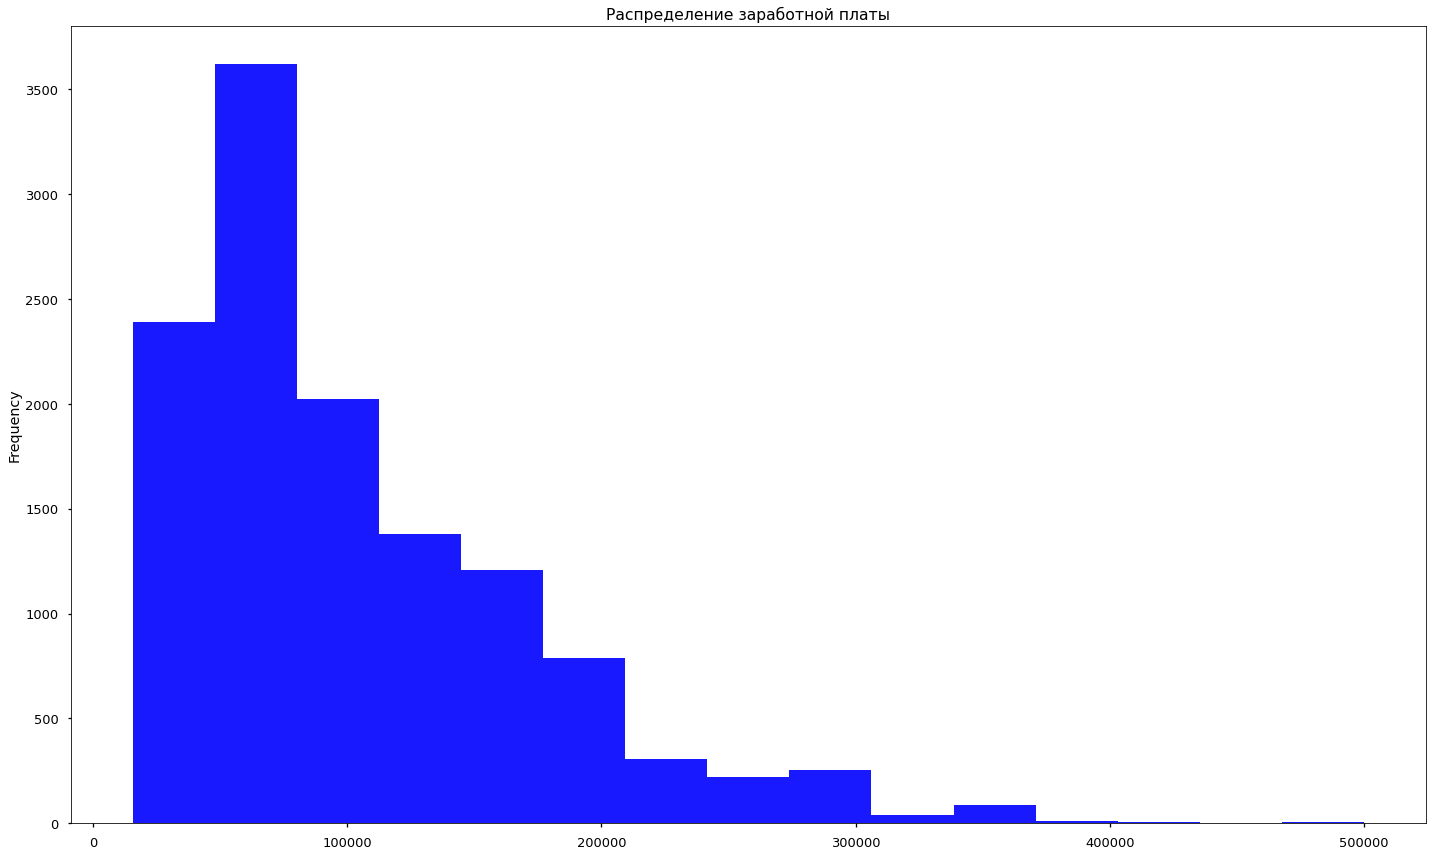

In [104]:
plt.figure(figsize=(20, 12))
plt.subplot(1, 1, 1)
plt.title('Распределение заработной платы')
exp['salary'].plot(kind='hist', alpha=0.9, color='blue', bins =15)
plt.tight_layout()
plt.show()

Распределение не является нормальным - так как оно не симмитрично.

In [105]:
stats.normaltest(exp.salary)

NormaltestResult(statistic=3020.412590393473, pvalue=0.0)

что подтверждается критерием Д'Агостино

### Взглянем на диаграммы распределения зарплат внутри выборок:

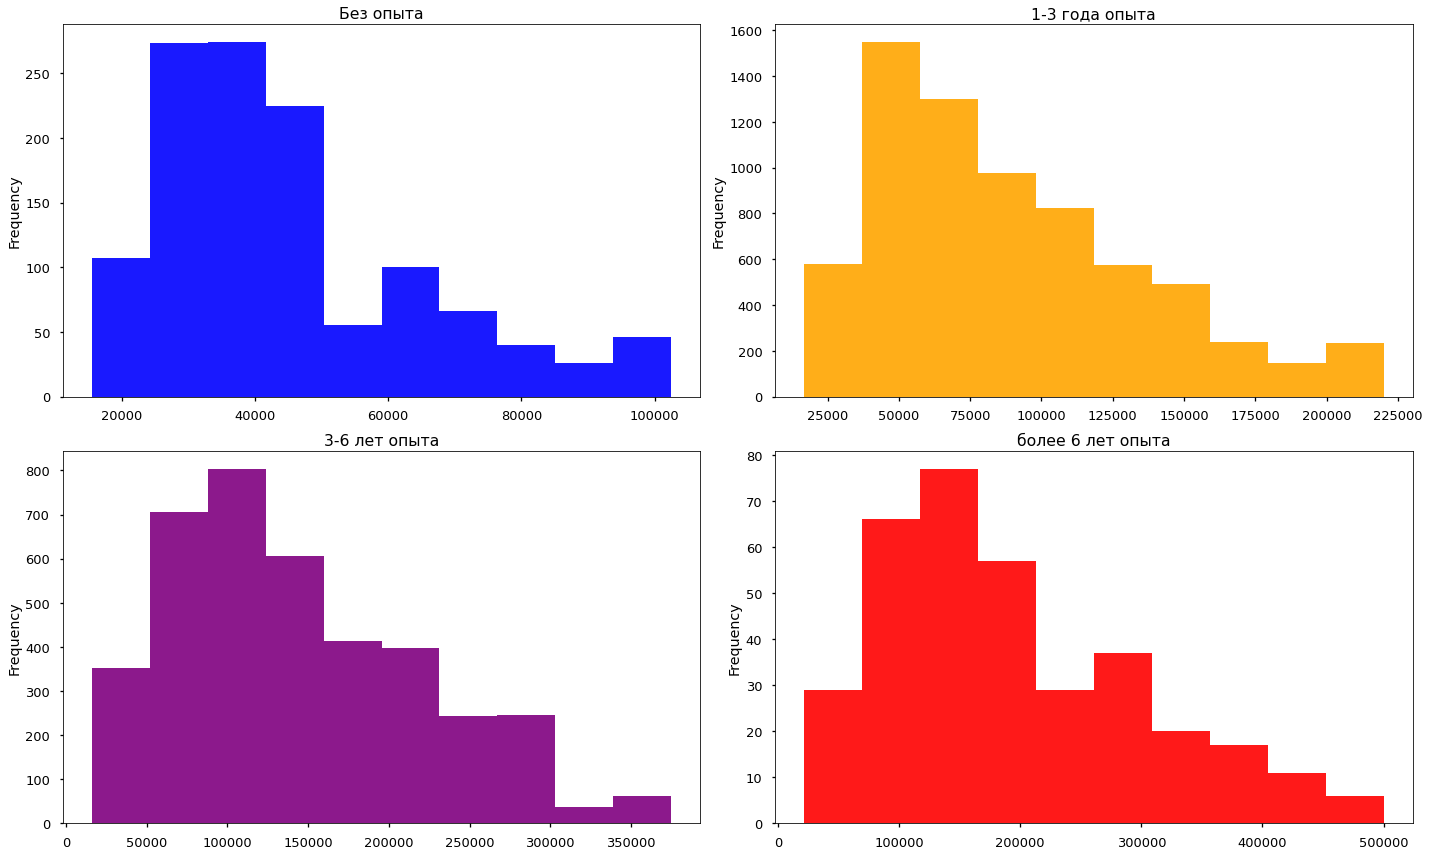

In [106]:

plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
plt.title('Без опыта')
exp0['salary'].plot(kind='hist', alpha=0.9, color='blue')
plt.subplot(2, 2, 2)
plt.title('1-3 года опыта')
exp1['salary'].plot(kind='hist', alpha=0.9, color='orange')
plt.subplot(2, 2, 3)
plt.title('3-6 лет опыта')
exp3['salary'].plot(kind='hist', alpha=0.9, color='purple')
plt.subplot(2, 2, 4)
plt.title('более 6 лет опыта')
exp6['salary'].plot(kind='hist', alpha=0.9, color='red')
plt.tight_layout()

plt.show()

# Прверка стат. гипотез и построение модели

## *Проверим* выборки на "нормальность"

так как в некоторых из выборок число элементов больше 5000, и критерий Шапиро-Уилкса не может гарантировать точности на таких выборках, воскользуемся критерием Д'Агостино.

In [107]:
stats.normaltest(exp0.salary)

NormaltestResult(statistic=156.67913312370843, pvalue=9.496389682338039e-35)

In [108]:
stats.normaltest(exp1.salary)

NormaltestResult(statistic=644.4409430987217, pvalue=1.1519330794204797e-140)

In [109]:
stats.normaltest(exp3.salary)

NormaltestResult(statistic=275.66533985528616, pvalue=1.3804860564842343e-60)

In [110]:
stats.normaltest(exp6.salary)

NormaltestResult(statistic=26.23929423270741, pvalue=2.0054399068601404e-06)

Ни одно из распределений не удовлетворяет критерию нормальности при альфа = 0.05


## Проверка корреляции переменных

Соответственно, для количественных данных с распределением не являющимся нормальным для количества групп больше 2 воспользуемся критерием **Краскала-Уолиса**

In [111]:
stats.kruskal(exp0.salary, exp1.salary,exp3.salary,exp6.salary)

KruskalResult(statistic=3280.4352944049483, pvalue=0.0)

Как мы видим пи-велью равен 0, что разумеется меньше альфа = 0.05, значит требуемый опыт существенно влияет на числовые характеристики случайной величины (уровень зарплаты)

Оценим корелляцию количественной характеристики(уровня зараотной платы) с порядковой(требованием к опыту) расчитав парный коэффициент корреляции Спирмена.

In [112]:
stats.spearmanr(exp['salary'], exp['experience'])

SpearmanrResult(correlation=0.5078010818170141, pvalue=0.0)

Пи велью равно 0, что меньше альфа, слледовательно гипотеза о незначимости кореляции отклоняется и выносится решение о том, что есть статистически значимая связь между требованием к опыту и заработной платой.

## Проверим гипотезу о зависимости заработной платы от вида занятости (удаленная/полный день)

In [113]:
exp.schedule.unique()

array(['Полный день', 'Удаленная работа'], dtype=object)

In [114]:
stats.spearmanr(exp['salary'], exp['schedule'])

SpearmanrResult(correlation=0.30885927687845705, pvalue=5.814222781883571e-271)

Пи велью значительно (10 в -271 степени) меньше альфа, слледовательно гипотеза о незначимости кореляции отклоняется, есть статистически значимая связь между требованием к опыту и заработной платой. Однако она меньше, чем связь требуемого опыта и заработной платы.  

## Сравнение категориальных факторов

Возможно переменные требуемого опыта и вида занятости являются зависимыми и вид занятости влияет на заработную плату не напрямую, а опосредовано - через требования по опыту работы, так как логично было бы предположить, что удаленную работу предлагают в основном сотрудникам уже имеющим какой-то опыт работы. Проверим гипотезу H0 о независимости факторов "schedule" и "expirience" отвечающих за тип занятости и требования по опыту работы соответственно.

In [115]:
freq_table = pd.crosstab(exp['experience'], exp['schedule']); 
freq_table

schedule,Полный день,Удаленная работа
experience,,
0,1143,69
1,5868,1045
3,2950,916
6,258,91


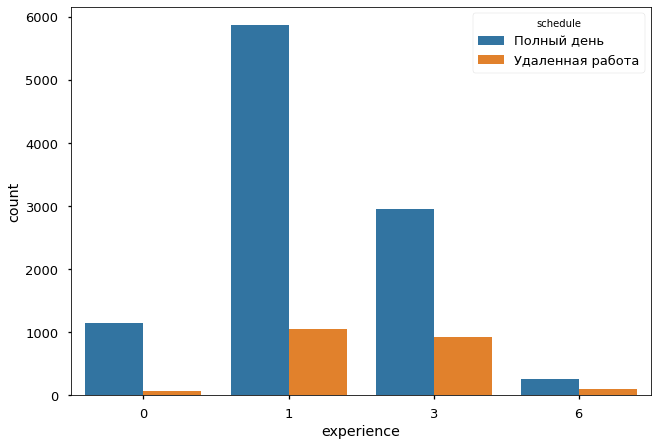

In [116]:
sns.countplot(x=exp['experience'], hue=exp['schedule'])

На графике визуально видна связь переменных, проверим, является ли она статистически значимой.

In [117]:
chi2_ = stats.chi2_contingency(freq_table)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%chi2_)

chisq-statistic=267.6735, p-value=0.0000, df=3 expected_frep=[[1003.68136143  208.31863857]
 [5724.79311183 1188.20688817]
 [3201.51166937  664.48833063]
 [ 289.01385737   59.98614263]]


Пи велью существенно меньше альфа, значит нулевая гипотеза о независимости категориальных факторов отклоняется и делается вывод что имеется связь между требуемым опытом работы и формой занятости.

## Регрессионная модель

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


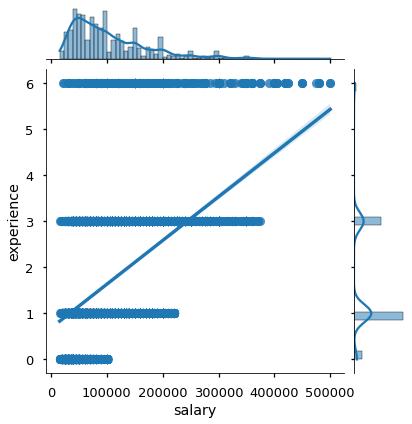

In [118]:
sns.jointplot('salary', 'experience', data=exp, kind="reg")

In [119]:
lin_regress = lm.LinearRegression()
modeled = lin_regress.fit(exp[['experience']],exp[['salary']])
print(f'intercept = {round(modeled.intercept_.item(),2)}, coef k = {round(modeled.coef_.item(),2)}')

intercept = 58743.0, coef k = 27051.64


In [120]:
modeled.score(exp[['experience']],exp[['salary']])

0.2568146565916838

Коэффециент детерминации составляет 26%. На 26% фактор (требуемый опыт) описывает целевой показатель. Да модель получилась неполной, а насколько значимым является данный фактор проверим с помощью метода ols библиотеки statmodels

In [121]:
import statsmodels.formula.api as smf
new_model = smf.ols('salary ~ experience', data=exp).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     4264.
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:49:48   Log-Likelihood:            -1.5294e+05
No. Observations:               12340   AIC:                         3.059e+05
Df Residuals:                   12338   BIC:                         3.059e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.874e+04    868.833     67.611      0.000     5.7e+04    6.04e+04
experience  2.705e+04    414.295     65.296      0.000    2.62e+04    2.79e+04
==============================================================================
Omnibus:                     1456.397   Durbin-Watson:                   0.473
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2248.494
Skew:                           0.855   Prob(JB):                         0.00
Kurtosis:                       4.204   Cond. No.                         4.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

пи велью близко к 0, много меньше альфа, значит мы надежно принимаем гипотезу о значимости модели, а также о том, что оба коэффициента важны.

Однако распределение остатков не является нормальным, так как пи велью при проверке их распределения по критерию Жарка Берра намного меньше 0 и гипотезу о соответствии распределения остатков нормальному распределения мы отвергаем.

# Вывод


Подтверждена H1 гипотеза о наличии свзяи между требованием к опыту и уровнем предлагаемой заработной платы.  Кореляционный коэффициент положительный, что говорит о прямой связи между случайными величинами. 
Мы принимаем гипотезу Н1 о значимости модели, а также о том, что оба вычесленных коэффициента важны.

Однако распределение остатков не является нормальным, так как пи велью при проверке их распределения по критерию Жарка Берра намного меньше 0 и гипотезу о соответствии распределения остатков нормальному распределения мы отвергаем и можем предположить что наша модель является не полной и нуждается в дополнении другими факторами.